# Splitting data

## Import

In [1]:
import sys
import os


import matplotlib
import matplotlib.pylab as plt
import time
import numpy as np
import open3d
from laspy.file import File
from laspy.header import Header

os.environ["PATH"]+=os.pathsep+os.path.dirname(sys.executable)


## Code helper

In [2]:
def las_to_open3d(path):
    """
    Loads an las or laz file and returns an open3d point cloud as well
    as the file's header. This is useful for saving the cloud back to disk
    """    
    inFile = File(path, mode='r')

    xyz = np.zeros((len(inFile.X),3),dtype=np.float32)
    xyz[:,0] = inFile.x
    xyz[:,1] = inFile.y
    xyz[:,2] = inFile.z
    colors = np.zeros((len(inFile.red),3),dtype=np.float32)
    try:
        colors[:,0] = inFile.red / 255
        colors[:,1] = inFile.green / 255
        colors[:,2] = inFile.blue / 255
    except:
        pass
    
    cloud = open3d.PointCloud()
    cloud.points = open3d.Vector3dVector(xyz)
    cloud.colors = open3d.Vector3dVector(xyz)

    return cloud,inFile.header

In [3]:
def plot_2d(clouds,axis_range=None,size = 100000,savefile = None,display=True, show_axis = False, wall_list_x = [], wall_list_y=[], additional_signal=None):
    """
    Plots a point cloud in 2d (in the x,y plane)
    You can use this function to generate images from the cloud and save to disk directly
    """
    try:
        #Init figure
        x_size = 20
        if axis_range:
            ratio = (axis_range[1] - axis_range[0])/(axis_range[3] - axis_range[2])
        else:
            ratio = 1
        fig = plt.figure(figsize=(x_size,x_size / ratio))
        
        #Print clouds
        for cloud in clouds:
            cloud_arr = np.asarray(cloud.points)
            if size > cloud_arr.shape[0]:
                idx = np.random.randint(len(cloud_arr), size=size)
                cloud_arr_sub = cloud_arr[idx,:]
            else:
                cloud_arr_sub = cloud_arr
            color = np.random.rand(3)
            plt.plot(cloud_arr_sub[:,0],cloud_arr_sub[:,1],"o",markersize=0.2,color=color)
        if additional_signal:
            plt.plot(additional_signal[0],additional_signal[1])
        plt.axis("equal")
        if axis_range:
            plt.axis(axis_range)
            for wall in wall_list_x:
                plt.plot([wall,wall],[axis_range[2],axis_range[3]],'k-')
            for wall in wall_list_y:
                plt.plot([axis_range[0],axis_range[1]],[wall, wall],'k-')
        if not show_axis:
            plt.axis('off')
        if savefile:
            plt.savefig(savefile,dpi=150)
        if display:
            plt.show()
    except Exception as e:
        print(e)

In [4]:
def get_floorceiling(cloud,min_distance_floor_cieling = 2 ):
    bin_size = 0.05
    z_histogram = create_histogram(cloud,bin_size,2)
    
    # extracts floors and celing
    sorted_counts = np.sort(z_histogram[0])
    lcounts = list(z_histogram[0])
    floor = 1e6
    ceiling = -1e6
    for i in range(len(sorted_counts)):
        counts = sorted_counts[-(i+1)]
        index = lcounts.index(counts)
        zlevel = z_histogram[1][index]
        if zlevel < floor:
            floor = zlevel
        if zlevel > ceiling:
            ceiling = zlevel
        if (ceiling - floor) > min_distance_floor_cieling:
            return (floor,ceiling,z_histogram)
    return (floor,ceiling,z_histogram)

def create_histogram(o3dcloud, bin_size=0.1, axis =2):
    numpy_cloud = np.asarray(o3dcloud.points)
    hmin = np.min(numpy_cloud[:,axis])
    hmax = np.max(numpy_cloud[:,axis])
    nb_bins = int(abs(hmax - hmin) / bin_size)
    return np.histogram(numpy_cloud[:,axis],bins = np.linspace(hmin,hmax,nb_bins))

# Data

## Loading Entire Point Cloud

In [6]:
#data_path = '../data/TEST/data/test/room_1900.ply'
#pcd = open3d.read_point_cloud(data_path)

#data_path = '../data/helix_bis/data/1600-google-amphi/1600ampFullPointCloud.las'
#cloud, header = las_to_open3d(data_path)

data_path = '../data/helix_bis/data/1950-charleston-road/level2.ply'
cloud03 = open3d.read_point_cloud(data_path)

## downsizing it (too massive)

In [6]:
small_cloud = open3d.voxel_down_sample(cloud, voxel_size = 0.03)

In [7]:
open3d.write_point_cloud('../data/helix_bis/data/1950-charleston-road/level2.ply', small_cloud)

True

## Splitting

In [7]:
#VOXEL_GRID = 0.03
#cloud03 = open3d.voxel_down_sample(cloud,VOXEL_GRID)

(floor,ceiling,z_histogram) = get_floorceiling(cloud03)
print("Floor level = " + str(floor))
print("Celing level = " + str(ceiling))

Floor level = -0.0245507580893376
Celing level = 3.0018419061388295


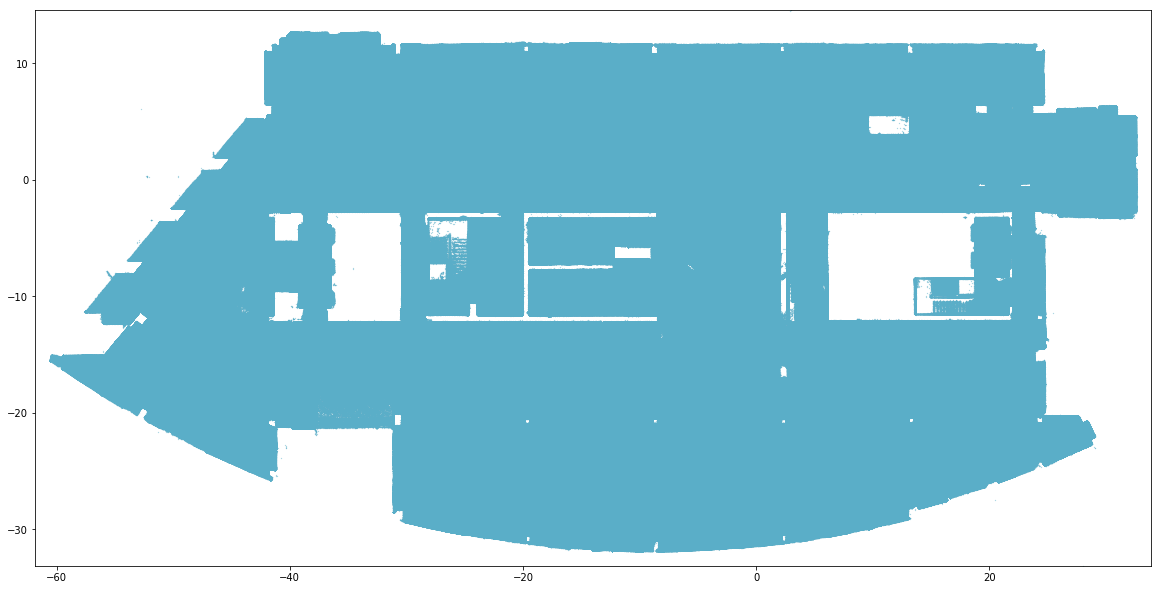

In [11]:
minbox = cloud03.get_min_bound()
maxbox = cloud03.get_max_bound()
ROOF_CEILING_PADDING = (ceiling - floor)*0.1
new_cloud03 = open3d.crop_point_cloud(cloud03,[minbox[0],minbox[1],floor - ROOF_CEILING_PADDING],[maxbox[0],maxbox[1],ceiling + ROOF_CEILING_PADDING])
plot_2d([new_cloud03],size = -1,axis_range=[minbox[0],maxbox[0],minbox[1],maxbox[1]],show_axis=True)

Getting 5 random crops at different size :

In [28]:
i = 0
while i < 5:
    x = np.random.randint(minbox[0], maxbox[0] - 9)
    y = np.random.randint(minbox[1], maxbox[1] - 9)
    rd_crop = open3d.crop_point_cloud(cloud03,[x,y,floor - ROOF_CEILING_PADDING],[x+8,y+8,ceiling + ROOF_CEILING_PADDING])
    open3d.write_point_cloud('../data/helix_bis/data/1950-charleston-road/test8_{}.ply'.format(i), rd_crop)
    i = i+1


In [42]:
open3d.write_point_cloud('../data/helix_bis/data/1600-google-amphi/test_11.ply', no_roofceiling_cloud03)

True

In [19]:
np.random.randint(0,10)

3

In [22]:
maxbox[1]

14.538394927978516

In [29]:
x = np.random.randint(minbox[0], maxbox[0] - 9)
y = np.random.randint(minbox[1], maxbox[1] - 9)
rd_crop = open3d.crop_point_cloud(cloud03,[x,y,floor - ROOF_CEILING_PADDING],[x+8,y+8,ceiling + ROOF_CEILING_PADDING])
open3d.write_point_cloud('../data/helix_bis/data/1950-charleston-road/test8_3.ply', rd_crop)

True